# ASTR-19 Individual Final Project

In this notebook, we will do the following:


1) Get astropy and install it on your system (pip install astropy).

2) Get sep and install it on your system (pip install sep).

3) Follow the tutorial found at https://sep.readthedocs.io/en/v1.0.x/tutorial.html, but use the astropy fits routines instead of fitsio. Create a notebook that performs the tutorial and comment it using Markdown to explain what it’s doing. Note that the fits image used in the tutorial can be acquired via the sep GitHub account.

4) Augment the tutorial to save each of the four figures to PNG files.


In [1]:
# Import all needed modules
import astropy
import astropy.io.fits
import sep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams

/home/eliott/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Now, we just need to define some stuff for matplotlib (like setting the figure size and that sort of stuff)

In [2]:
# additional setup for reading the test image and displaying plots
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Next, we load the image into the variable labelled data. Data is internally just a 2d np array - note since we're not dealing with RGBA images, but just black and white, the array does not need to be 3D. (as in Width_x, Height_y, Channels_z)

In [3]:
# read image into standard 2-d numpy array
astropy_image = astropy.io.fits.open("image.fits")
data = astropy_image[0].data

# If this barfs with errors about non-native byte order, swap the endianness
#data = data.byteswap(inplace=True).newbyteorder()


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


After that, we're just going to plot the image as is, just so we can see what's going on in it. This is of course going to be automatically annotated later on (to search for unique features) (we could also use OpenCV to do this, no?)

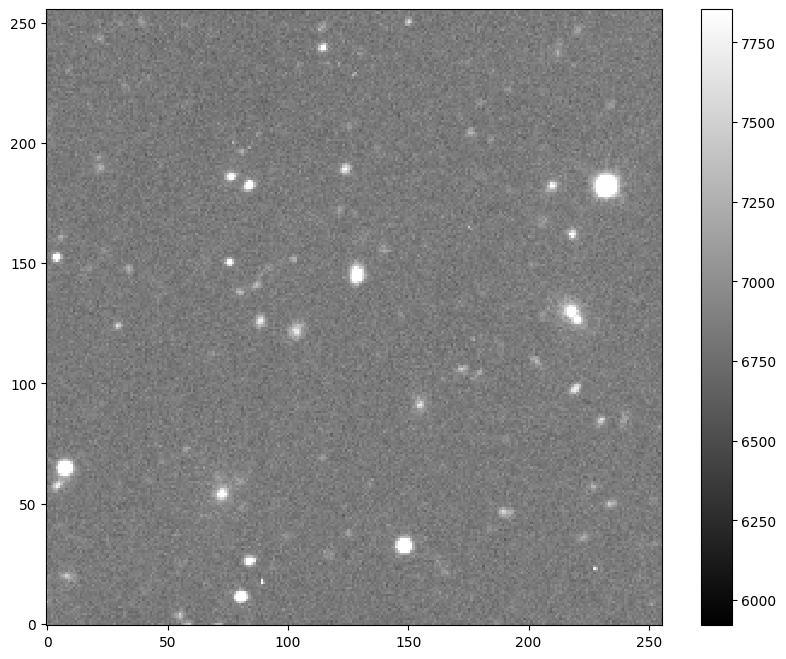

In [4]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.savefig("1.png")
plt.colorbar();

Now, we subtract the background from the image (remove the noisefloor, to enable the features to stand out and be segmented more easily.)

This is done in multiple steps, firstly, we find the average of the background, in terms of avg color, then this is used to identify what the mean color is.


In [10]:
# evaluate background as 2-d array, same size as original image
bkg = sep.Background(data)
bkg_image = bkg.back()

Next, it's time to generate a picture of this averaged background or noies floor, note that it's been interpolated, so a lot of the fine noise isn't going to be there, which is why it looks smooth.

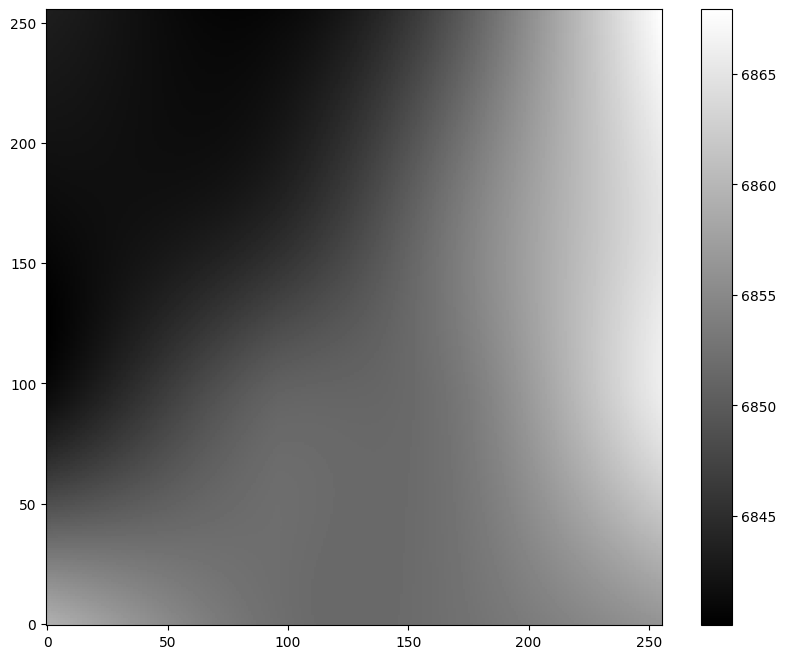

In [11]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.savefig("2.png")
plt.colorbar();

After that, we're going to make the bkg we calculated into a 2d arr scaled to match the image dimensions.

In [12]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

Now, we can make another pretty graph showing that!

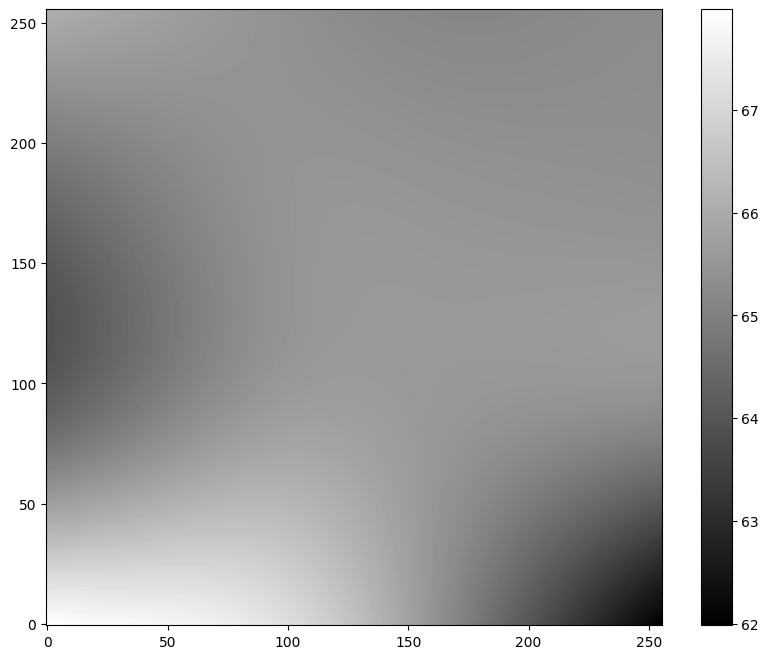

In [13]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.savefig("3.png")
plt.colorbar();

Okay, now we're going to remove that background from the source image, so that it just contains the features standing out above the noise background.

In [14]:
# subtract the background
data_sub = data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

Here, we can get a count of the total num features that were extraced.

In [15]:
# how many objects were detected
len(objects)

69

Now, we're goint to draw elipses around the features that we spotted, and plot that on an image.

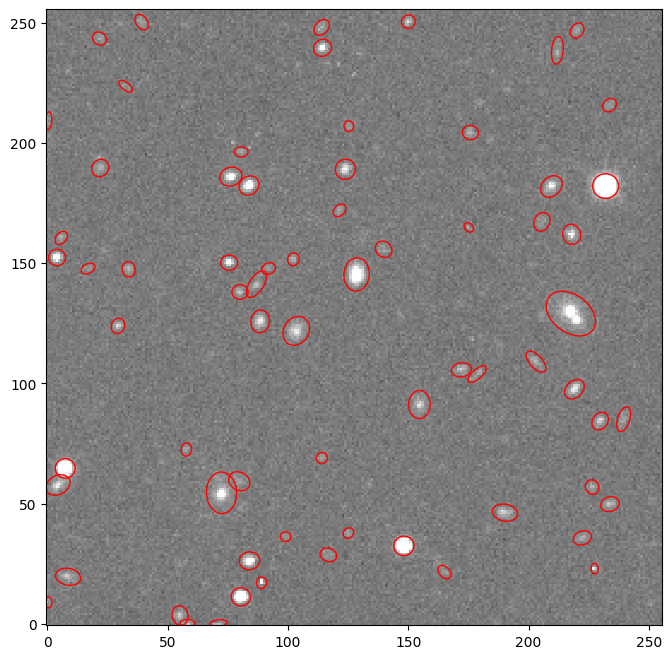

In [16]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("4.png")


Here, we will calculate the fluxes and error margins for the first ten features identified.

In [17]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [18]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138


Done!